# Forex Arbitrage

This notebook presents an example of linear optimization on a network model for financial transactions. The goal is to identify whether or not an arbitrage opportunity exists given a matrix of cross-currency exchange rates. Other treatments of this problem and application are available, including the following links.

* [Crypto Arbitrage Framework](https://github.com/hzjken/crypto-arbitrage-framework)
* [Crypto Trading and Arbitrage Identification Strategies](https://nbviewer.org/github/rcroessmann/sharing_public/blob/master/arbitrage_identification.ipynb)


In [ ]:
# install dependencies and select solver
%pip install -q amplpy networkx numpy pandas

SOLVER = "cbc"

from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["cbc"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

In [ ]:
import io
import networkx as nx
import numpy as np
import pandas as pd

## Problem

Exchanging one currency for another is among the most common of all banking transactions. Currencies are normally priced relative to each other. 

At this moment of this writing, for example, the Japanese yen (symbol JPY) is priced at 0.00761 relative to the euro (symbol EUR). At this price 100 euros would purchase 100/0.00761 = 13,140.6 yen. Conversely, EUR is priced at 131.585 yen.  The 'round-trip' of 100 euros from EUR to JPY and back to EUR results in

$$100 \text{ EUR} \times \frac{1\text{ JPY}}{0.00761\text{ EUR}} {\quad\longrightarrow\quad} 12,140.6 \text{ JPY} \times\frac{1\text{ EUR}}{131.585\text{ JPY}} {\quad\longrightarrow\quad} 99.9954\text{ EUR}$$

The small loss in this round-trip transaction is the fee collected by the brokers and banking system to provide these services. 

Needless to say, if a simple round-trip transaction like this reliably produced a net gain then there would many eager traders ready to take advantage of the situation. Trading situations offering a net gain with no risk are called arbitrage, and are the subject of intense interest by traders in the foreign exchange (forex) and crypto-currency markets around the globe.

As one might expect, arbitrage opportunities involving a simple round-trip between a pair of currencies are almost non-existent in real-world markets. When the do appear, they are easily detected and rapid and automated trading  quickly exploit the situation. More complex arbitrage opportunities, however, can arise when working with three more currencies and a table of cross-currency exchange rates.



## Demonstration of Triangular Arbitrage

Consider the following cross-currency matrix. 

| i <- J | USD | EUR | JPY |
| :--- | :---: | :---: | :---: |
| USD | 1.0 | 2.0 | 0.01 |
| EUR | 0.5 | 1.0 | 0.0075 |
| JPY | 100.0 | 133 1/3 | 1.0 |


Entry $a_{m, n}$ is the number units of currency $m$ received in exchange for one unit of currency $n$.  We use the notation 

$$a_{m, n} = a_{m \leftarrow n}$$

as reminder of what the entries denote. For this data there are no two way arbitrage opportunities. We can check this by explicitly computing all two-way currency exchanges

$$I \rightarrow J \rightarrow I$$

by computing

$$ a_{i \leftarrow j} \times a_{j \leftarrow i}$$

This data set shows no net cost and no arbitrage for conversion from one currency to another and back again.

In [2]:
df = pd.DataFrame(
    [[1.0, 0.5, 100], [2.0, 1.0, 1 / 0.0075], [0.01, 0.0075, 1.0]],
    columns=["USD", "EUR", "JPY"],
    index=["USD", "EUR", "JPY"],
).T

display(df)

# USD -> EUR -> USD
print(df.loc["USD", "EUR"] * df.loc["EUR", "USD"])

# USD -> JPY -> USD
print(df.loc["USD", "JPY"] * df.loc["JPY", "USD"])

# EUR -> JPY -> EUR
print(df.loc["EUR", "JPY"] * df.loc["JPY", "EUR"])

,USD,EUR,JPY
USD,1.0,2.000000,0.0100
EUR,0.5,1.000000,0.0075
JPY,100.0,133.333333,1.0000


1.0
1.0
1.0


Now consider a currency exchange comprised of three trades that returns back to the same currency.

$$ I \rightarrow J \rightarrow K \rightarrow I $$

The net exchange rate can be computed as

$$ a_{i \leftarrow k} \times a_{k \leftarrow j} \times a_{j \leftarrow i} $$

By direct calculation we see there is a three-way **triangular** arbitrage opportunity for this data set that returns a 50% increase in wealth.

In [3]:
I = "USD"
J = "JPY"
K = "EUR"

print(df.loc[I, K] * df.loc[K, J] * df.loc[J, I])

1.5


Our challenge is create a model that can identify complex arbitrage opportunities that may exist in cross-currency forex markets.

## Modeling

The cross-currency table $A$ provides exchange rates among currencies. Entry $a_{i,j}$ in row $i$, column $j$ tells us how many units of currency $i$ are received in exchange for one unit of currency $j$. We'll use the notation $a_{i, j} = a_{i\leftarrow j}$ to remind ourselves of this relationship.

We start with $w_j(0)$ units of currency $j \in N$, where $N$ is the set of all currencies in the data set. We consider a sequence of trades $t = 1, 2, \ldots, T$ where $w_j(t)$ is the amount of currency $j$ on hand after completing trade $t$.

Each trade is executed in two phases. In the first phase an amount $x_{i\leftarrow j}(t)$  of currency $j$ is committed for exchange to currency $i$. This allows a trade to include multiple currency transactions. After the commitment the unencumbered balance for currency $j$ must satisfy trading constraints. Each trade consists of simultaneous transactions in one or more currencies.

$$w_j(t-1) - \sum_{i\ne j} x_{i\leftarrow j}(t) \geq 0$$

Here a lower bound has been placed to prohibit short-selling of currency $j$. This constraint could be modified if leveraging is allowed on the exchange.

The second phase of the trade is complete when the exchange credits all of the currency accounts according to

$$ w_j(t) = w_j(t-1) - \underbrace{\sum_{i\ne j} x_{i\leftarrow j}(t)}_{\text{outgoing}} + \underbrace{\sum_{i\ne j} a_{j\leftarrow i}x_{j\leftarrow i}(t)}_{\text{incoming}} $$

We assume all trading fees and costs are represented in the bid/ask spreads represented by $a_{j\leftarrow i}$

The goal of this calculation is to find a set of transactions $x_{i\leftarrow j}(t) \geq 0$ to maximize the value of portfolio after a specified number of trades $T$.


In [4]:
%%writefile arbitrage.mod

set T0;
set T1;
    
# currency *nodes*
set NODES;

# paths between currency nodes i -> j
set ARCS within {NODES,NODES};

param T;
param R symbolic;
param a{NODES, NODES};

# w[i, t] amount of currency i on hand after transaction t
var w{NODES, T0} >= 0;

# x[m, n, t] amount of currency m converted to currency n in transaction t t
var x{ARCS, T1} >= 0;

# start with assignment of 100 units of a selected reserve currency
s.t. initial_condition{i in NODES}:
    w[i, 0] == (if i == R then 100 else 0);

# no shorting constraint
s.t. max_trade {j in NODES, t in T1}:
    w[j, t-1] >= sum{i in NODES: i != j} x[i, j, t];

# one round of transactions
s.t. balances {j in NODES, t in T1}:
    w[j, t] ==
        w[j, t-1] - 
        sum{i in NODES: i != j} x[i, j, t] + 
        sum{i in NODES: i != j} a[j, i] * x[j, i, t];

maximize wealth: w[R, T];

Overwriting arbitrage.mod


In [5]:
def arbitrage(T, df, R="EUR"):
    m = AMPL()
    m.read("arbitrage.mod")

    T0 = list(range(0, T + 1))
    T1 = list(range(1, T + 1))
    NODES = df.index
    ARCS = [(i, j) for i in NODES for j in NODES if i != j]

    m.set["T0"] = T0
    m.set["T1"] = T1
    m.set["NODES"] = NODES
    m.set["ARCS"] = ARCS
    m.param["T"] = T
    m.param["R"] = R
    m.param["a"] = df

    m.option["solver"] = SOLVER
    m.solve()

    x = m.var["x"].to_dict()
    w = m.var["w"].to_dict()

    for t in T0:
        print(f"\nt = {t}\n")
        if t >= 1:
            for i, j in ARCS:
                if x[i, j, t] > 0:
                    print(
                        f"{j} -> {i}  Convert {x[i, j, t]} {j} to {df.loc[i,j]*x[i,j,t]} {i}"
                    )
            print()

        for i in NODES:
            print(f"w[{i},{t}] = {w[i, t]:9.2f} ")

    return m


m = arbitrage(3, df, "EUR")
w = m.var["w"].to_dict()
print(w["EUR", 0])
print(w["EUR", 3])

cbc 2.10.7: cbc 2.10.7: optimal solution; objective 150
0 simplex iterations

t = 0

w[USD,0] =      0.00 
w[EUR,0] =    100.00 
w[JPY,0] =      0.00 

t = 1

EUR -> USD  Convert 100 EUR to 200.0 USD

w[USD,1] =    200.00 
w[EUR,1] =     -0.00 
w[JPY,1] =      0.00 

t = 2

USD -> JPY  Convert 200 USD to 20000.0 JPY

w[USD,2] =      0.00 
w[EUR,2] =      0.00 
w[JPY,2] =  20000.00 

t = 3

JPY -> EUR  Convert 20000.00000000001 JPY to 150.00000000000009 EUR

w[USD,3] =      0.00 
w[EUR,3] =    150.00 
w[JPY,3] =      0.00 
100
150.0000000000001


## Display graph


 100 EUR -> 200 USD -> 20000 JPY -> 150.0000000000001 EUR


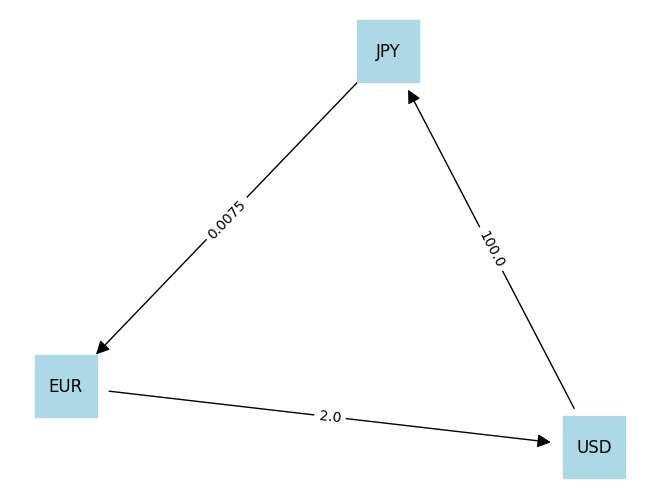

In [6]:
def display_graph(m):
    m_w = m.var["w"].to_dict()
    m_x = m.var["x"].to_dict()

    T0 = m.set["T0"].to_list()
    T1 = m.set["T1"].to_list()
    NODES = m.set["NODES"].to_list()
    ARCS = m.set["ARCS"].to_list()

    path = []

    for t in T0:
        for i in NODES:
            if m_w[i, t] >= 1e-6:
                path.append(f"{m_w[i, t]} {i}")
    path = " -> ".join(path)
    print("\n", path)

    G = nx.DiGraph()
    for i in NODES:
        G.add_node(i)
    nodelist = set()
    edge_labels = dict()

    for t in T1:
        for i, j in ARCS:
            if m_x[i, j, t] > 0.1:
                nodelist.add(i)
                nodelist.add(j)
                y = m_w[j, t - 1]
                x = m_w[j, t]
                G.add_edge(j, i)
                edge_labels[(j, i)] = df.loc[i, j]

    nodelist = list(nodelist)
    pos = nx.spring_layout(G)
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=2000,
        nodelist=nodelist,
        node_color="lightblue",
        node_shape="s",
        arrowsize=20,
        label=path,
    )
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)


display_graph(m)

## FOREX data

https://www.bloomberg.com/markets/currencies/cross-rates

https://www.tradingview.com/markets/currencies/cross-rates-overview-prices/

In [7]:
# data extracted 2022-03-17

bloomberg = """
	USD	EUR	JPY	GBP	CHF	CAD	AUD	HKD
USD	-	1.1096	0.0084	1.3148	1.0677	0.7915	0.7376	0.1279
EUR	0.9012	-	0.0076	1.1849	0.9622	0.7133	0.6647	0.1153
JPY	118.6100	131.6097	-	155.9484	126.6389	93.8816	87.4867	15.1724
GBP	0.7606	0.8439	0.0064	-	0.8121	0.6020	0.5610	0.0973
CHF	0.9366	1.0393	0.0079	1.2314	-	0.7413	0.6908	0.1198
CAD	1.2634	1.4019	0.0107	1.6611	1.3489	-	0.9319	0.1616
AUD	1.3557	1.5043	0.0114	1.7825	1.4475	1.0731	-	0.1734
HKD	7.8175	8.6743	0.0659	10.2784	8.3467	6.1877	5.7662	-
"""


df = pd.read_csv(io.StringIO(bloomberg.replace("-", "1.0")), sep="\t", index_col=0)
display(df)

,USD,EUR,JPY,GBP,CHF,CAD,AUD,HKD
USD,1.0000,1.1096,0.0084,1.3148,1.0677,0.7915,0.7376,0.1279
EUR,0.9012,1.0000,0.0076,1.1849,0.9622,0.7133,0.6647,0.1153
JPY,118.6100,131.6097,1.0000,155.9484,126.6389,93.8816,87.4867,15.1724
GBP,0.7606,0.8439,0.0064,1.0000,0.8121,0.6020,0.5610,0.0973
CHF,0.9366,1.0393,0.0079,1.2314,1.0000,0.7413,0.6908,0.1198
CAD,1.2634,1.4019,0.0107,1.6611,1.3489,1.0000,0.9319,0.1616
AUD,1.3557,1.5043,0.0114,1.7825,1.4475,1.0731,1.0000,0.1734
HKD,7.8175,8.6743,0.0659,10.2784,8.3467,6.1877,5.7662,1.0000


In [8]:
m = arbitrage(3, df, "USD")

cbc 2.10.7: cbc 2.10.7: optimal solution; objective 100.451402
0 simplex iterations

t = 0

w[USD,0] =    100.00 
w[EUR,0] =      0.00 
w[JPY,0] =      0.00 
w[GBP,0] =      0.00 
w[CHF,0] =      0.00 
w[CAD,0] =      0.00 
w[AUD,0] =      0.00 
w[HKD,0] =      0.00 

t = 1

USD -> JPY  Convert 100 USD to 11861.0 JPY

w[USD,1] =      0.00 
w[EUR,1] =      0.00 
w[JPY,1] =  11861.00 
w[GBP,1] =      0.00 
w[CHF,1] =      0.00 
w[CAD,1] =      0.00 
w[AUD,1] =      0.00 
w[HKD,1] =      0.00 

t = 2

GBP -> JPY  Convert 2.399951029481301e-13 GBP to 3.742685231259617e-11 JPY
AUD -> GBP  Convert 2.851001950900435e-13 AUD to 1.599412094455144e-13 GBP
JPY -> CAD  Convert 11861 JPY to 126.91269999999999 CAD
CAD -> AUD  Convert 2.65817100640753e-13 CAD to 2.85248330697592e-13 AUD
AUD -> HKD  Convert 1.426981268386952e-13 AUD to 8.228259389772843e-13 HKD

w[USD,2] =      0.00 
w[EUR,2] =      0.00 
w[JPY,2] =     -0.00 
w[GBP,2] =      0.00 
w[CHF,2] =      0.00 
w[CAD,2] =    126.9


 100 USD -> 11861 JPY -> 126.9127 CAD -> 100.45140205 USD


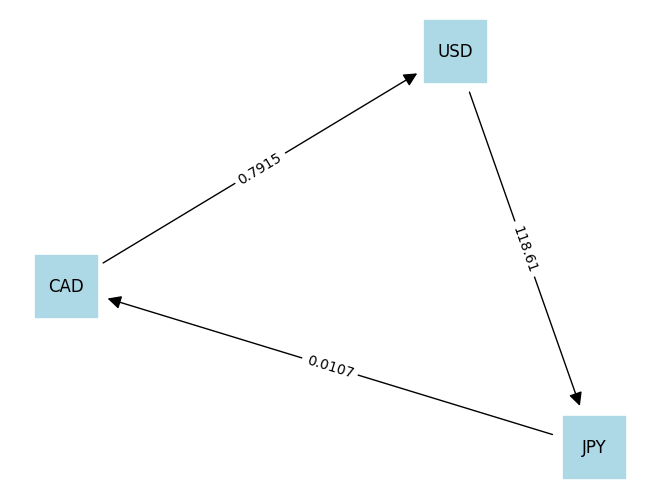

In [9]:
display_graph(m)